In [446]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [461]:
data = pd.read_parquet('~/Downloads/child-mind-institute-detect-sleep-states/train_series.parquet')

In [462]:
data = data.set_index('series_id')

In [485]:
events = pd.read_csv('~/Downloads/child-mind-institute-detect-sleep-states/train_events.csv')
events = events[~events['step'].isna()]
events = events.sort_values('timestamp')

# there are some duplicate events (looks like they are at same time in different time zone)
events = events.drop_duplicates(subset=['series_id', 'night', 'event'])

events = events.set_index('series_id')

In [1]:
events

NameError: name 'events' is not defined

In [428]:
events.groupby('series_id')['night'].nunique().describe()

count    269.000000
mean      17.825279
std        8.294214
min        1.000000
25%       12.000000
50%       19.000000
75%       23.000000
max       35.000000
Name: night, dtype: float64

In [429]:
events['series_id'].nunique()

269

In [489]:
events.groupby(['series_id', 'night', 'event']).size().sort_values(ascending=False)

series_id     night  event 
038441c925bb  1      onset     1
b4b75225b224  1      wakeup    1
              2      wakeup    1
              3      onset     1
                     wakeup    1
                              ..
55a47ff9dc8a  15     wakeup    1
              16     onset     1
                     wakeup    1
              17     onset     1
fe90110788d2  34     wakeup    1
Length: 9584, dtype: int64

In [490]:
def remove_missing_data():
    cleaned_data = []
    series_ids = events.index.unique()
    for series_id in tqdm(series_ids):
        series_events = events.loc[series_id]
        series_data = data.loc[series_id]
        
        # Remove nights where there isn't a complete record
        event_counts = series_events.groupby('night').size()
        if (event_counts < 2).any():
            event_counts = event_counts.reset_index().rename(columns={0: 'count'})
            invalid_nights = event_counts[event_counts['count'] < 2]['night']
            series_events = series_events[~series_events['night'].isin(invalid_nights)]

        missing_night_idxs = np.where(series_events['night'].diff() > 1)[0]
        cleaned_series = series_data.copy()
        if len(missing_night_idxs) > 1:
            for missing_night_idx in missing_night_idxs:
                from_time = series_events.iloc[missing_night_idx]['timestamp']
                to_time = series_events.iloc[missing_night_idx-1]['timestamp']
                cleaned_series = cleaned_series[~((cleaned_series['timestamp'] > from_time) &
                                                  (cleaned_series['timestamp'] < to_time))]
        if series_events['night'].min() != 1:
            # If the first night in the data is not the first, remove everything that came before it
            # since we don't know what happened
            from_time = series_events[series_events['event'] == 'onset'].iloc[0]['timestamp']
            cleaned_series = cleaned_series[cleaned_series['timestamp'] >= from_time]
        
        # remove everything past last event (don't know if there is missing data after)
        from_time = series_events[series_events['event'] == 'wakeup'].iloc[-1]['timestamp']
        cleaned_series = cleaned_series[cleaned_series['timestamp'] <= from_time]
        
        cleaned_data.append(cleaned_series)
    return pd.concat(cleaned_data)

In [463]:
data.shape

(127946340, 4)

In [491]:
data = remove_missing_data()

100%|██████████| 269/269 [12:21<00:00,  2.76s/it]


In [492]:
data.shape

(96683501, 4)

In [473]:
data = data.sort_values('timestamp')

In [517]:
def generate_metadata():
    """
    generates csv file containing series_id, start, end, night, label
    :return: 
    """
    res = []
    series_ids = events.index.unique()
    for series_id in tqdm(series_ids):
        series_events = events.loc[series_id]
        series_data = data.loc[series_id]
        prev_sleep_end = -1
        prev_night = 0
        prev_night_valid_sleep = True

        for i, night in enumerate(sorted(series_events['night'].unique())):
            night_events = series_events[series_events['night'] == night]
            
            if len(night_events) != 2:
                prev_night_valid_sleep = False
                continue
            
            if night != prev_night + 1:
                prev_night_valid_sleep = False
                
            if (i == 0 and night != 1) or not prev_night_valid_sleep:
                awake_start = None
                awake_end = None
            else:
                try:
                    awake_start = prev_sleep_end + 1
                    awake_end = np.where(series_data['timestamp'] == 
                                   night_events[night_events['event'] == 'onset'].iloc[0]['timestamp'])[0][0] - 1
                except IndexError:
                    awake_start = None
                    awake_end = None
                    
            if awake_end is not None:
                sleep_start = awake_end + 1
            else:
                sleep_start = np.where(series_data['timestamp'] == 
                           night_events[night_events['event'] == 'onset'].iloc[0]['timestamp'])[0][0]
            sleep_end = np.where(series_data['timestamp'] == 
                           night_events[night_events['event'] == 'wakeup'].iloc[0]['timestamp'])[0][0]
            prev_sleep_end = sleep_end
            prev_night_valid_sleep = True
            prev_night = night
            
            if awake_start is not None and awake_end is not None:
                res.append({
                    'series_id': series_id,
                    'start': awake_start,
                    'end': awake_end,
                    'night': night,
                    'label': 'awake'
                })
            res.append({
                'series_id': series_id,
                'start': sleep_start,
                'end': sleep_end,
                'night': night,
                'label': 'sleep'
            })
    res = pd.DataFrame(res)
    return res
                

In [518]:
meta = generate_metadata()

100%|██████████| 269/269 [14:47<00:00,  3.30s/it]


In [519]:
meta

,series_id,start,end,night,label
0,fe90110788d2,0,6804,2,sleep
1,fe90110788d2,6805,17015,3,awake
2,fe90110788d2,17016,21336,3,sleep
3,fe90110788d2,21337,33011,4,awake
4,fe90110788d2,33012,41712,4,sleep
...,...,...,...,...,...
9083,c535634d7dcd,93672,100428,6,sleep
9084,c535634d7dcd,100429,111599,7,awake
9085,c535634d7dcd,111600,117492,7,sleep
9086,c535634d7dcd,117493,127955,8,awake


In [520]:
(meta['end'] - meta['start']).describe()

count     9088.000000
mean      8387.272887
std       2741.011235
min        576.000000
25%       6247.500000
50%       7602.000000
75%      10738.000000
max      18226.000000
dtype: float64

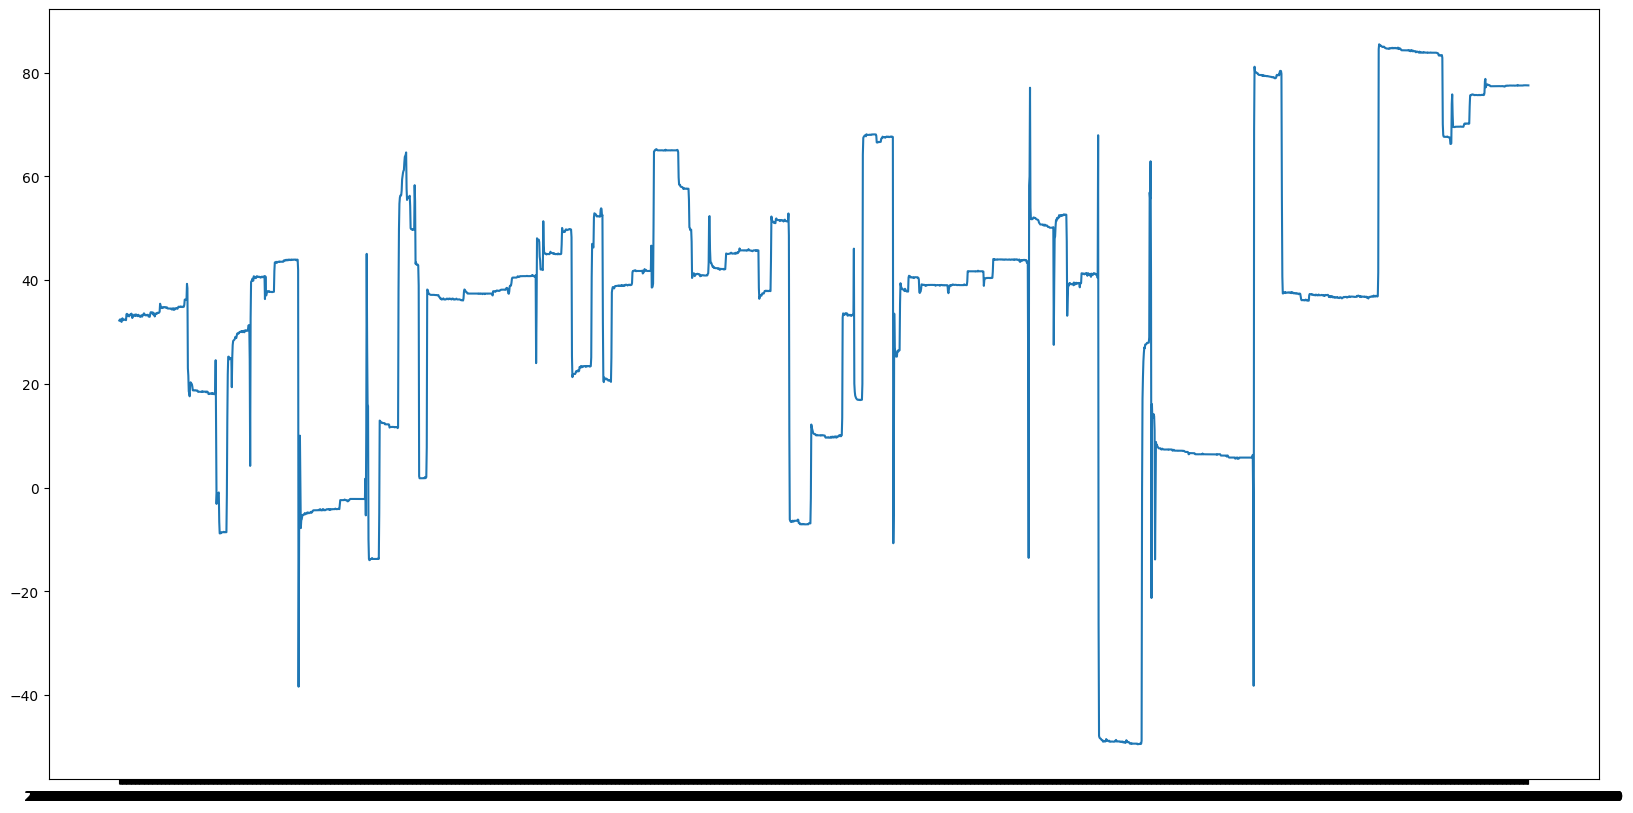

In [514]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(data.loc['e34b496b84ce'].iloc[320976:324120+1]['timestamp'], data.loc['e34b496b84ce'].iloc[320976:324120+1]['anglez'])
plt.show()

In [507]:
events.loc['fe90110788d2']

,night,event,step,timestamp
series_id,,,,
fe90110788d2,2,onset,21048.0,2017-08-05T22:44:00-0400
fe90110788d2,2,wakeup,27852.0,2017-08-06T08:11:00-0400
fe90110788d2,3,onset,38064.0,2017-08-06T22:22:00-0400
fe90110788d2,3,wakeup,42384.0,2017-08-07T04:22:00-0400
fe90110788d2,4,onset,54060.0,2017-08-07T20:35:00-0400
...,...,...,...,...
fe90110788d2,32,wakeup,547152.0,2017-09-05T09:26:00-0400
fe90110788d2,33,onset,556560.0,2017-09-05T22:30:00-0400
fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400


In [500]:
events.loc['0ce74d6d2106']

,night,event,step,timestamp
series_id,,,,
0ce74d6d2106,1,onset,4812.0,2017-08-21T23:11:00-0400
0ce74d6d2106,1,wakeup,10344.0,2017-08-22T06:52:00-0400
0ce74d6d2106,2,onset,22356.0,2017-08-22T23:33:00-0400
0ce74d6d2106,2,wakeup,28296.0,2017-08-23T07:48:00-0400
0ce74d6d2106,3,onset,39228.0,2017-08-23T22:59:00-0400
...,...,...,...,...
0ce74d6d2106,30,wakeup,510864.0,2017-09-20T06:02:00-0400
0ce74d6d2106,31,onset,523080.0,2017-09-20T23:00:00-0400
0ce74d6d2106,31,wakeup,528564.0,2017-09-21T06:37:00-0400


In [459]:
data['timestamp']

series_id
fe90110788d2    2017-08-04T17:30:00-0400
fe90110788d2    2017-08-04T17:30:05-0400
fe90110788d2    2017-08-04T17:30:10-0400
fe90110788d2    2017-08-04T17:30:15-0400
fe90110788d2    2017-08-04T17:30:20-0400
                          ...           
c535634d7dcd    2019-07-05T09:14:35-0400
c535634d7dcd    2019-07-05T09:14:40-0400
c535634d7dcd    2019-07-05T09:14:45-0400
c535634d7dcd    2019-07-05T09:14:50-0400
c535634d7dcd    2019-07-05T09:14:55-0400
Name: timestamp, Length: 266420340, dtype: object

In [416]:
pd.to_datetime('2018-08-22T16:15:00-0400').hour

16

In [413]:
pd.to_datetime(data['timestamp'], utc=True)
#data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True)

59836140    2018-08-22 20:15:00+00:00
59836141    2018-08-22 20:15:05+00:00
59836142    2018-08-22 20:15:10+00:00
59836143    2018-08-22 20:15:15+00:00
59836144    2018-08-22 20:15:20+00:00
                       ...           
126733315   2018-04-23 04:59:35+00:00
126733316   2018-04-23 04:59:40+00:00
126733317   2018-04-23 04:59:45+00:00
126733318   2018-04-23 04:59:50+00:00
126733319   2018-04-23 04:59:55+00:00
Name: timestamp, Length: 1999800, dtype: datetime64[ns, UTC]

In [194]:
data

,series_id,step,timestamp,anglez,enmo
31480200,3be2f86c3e45,0,2018-01-17 16:15:00+00:00,-14.083300,0.0440
31480201,3be2f86c3e45,1,2018-01-17 16:15:05+00:00,-23.519800,0.0653
31480202,3be2f86c3e45,2,2018-01-17 16:15:10+00:00,-21.065100,0.0628
31480203,3be2f86c3e45,3,2018-01-17 16:15:15+00:00,-22.851200,0.0536
31480204,3be2f86c3e45,4,2018-01-17 16:15:20+00:00,-22.221399,0.0499
...,...,...,...,...,...
34500235,416354edd92a,607855,2018-12-01 23:59:35+00:00,-45.616798,0.0276
34500236,416354edd92a,607856,2018-12-01 23:59:40+00:00,-40.760700,0.0236
34500237,416354edd92a,607857,2018-12-01 23:59:45+00:00,-30.782200,0.0484
34500238,416354edd92a,607858,2018-12-01 23:59:50+00:00,-16.554399,0.1034


In [195]:
series_ids = data['series_id'].unique()

In [196]:
def plot_series(series_id, sleep_num=1, from_time=None, upto_time=None):
    fix, ax = plt.subplots(nrows=2, figsize=(20, 10))
    series = data[data['series_id'] == series_id]
    series_events = events[events['series_id'] == series_id]
    series_events = series_events.sort_values('timestamp')
    
    if from_time is None and upto_time is None:
        from_time = series_events[series_events['event'] == 'onset']['timestamp'].iloc[sleep_num-1]
        upto_time = series_events[series_events['event'] == 'onset']['timestamp'].iloc[sleep_num]
    
    if from_time is None and upto_time is None:
        series_data = series[(series['timestamp'] > from_time - pd.Timedelta(hours=4)) & 
                       (series['timestamp'] < upto_time + pd.Timedelta(hours=4))]
        series_events = series_events[(series_events['timestamp'] > from_time - pd.Timedelta(hours=4)) & 
                                     (series_events['timestamp'] < upto_time + pd.Timedelta(hours=4))]
    else:
        series_data = series[(series['timestamp'] > from_time) & 
                       (series['timestamp'] < upto_time)] 
        series_events = series_events[(series_events['timestamp'] > from_time) & 
                             (series_events['timestamp'] < upto_time)]
    ax[0].plot(series_data['timestamp'], series_data['anglez'])
    ax[1].plot(series_data['timestamp'], series_data['enmo'])
    
    for event in series_events.itertuples(index=False):
        if event.event == 'onset':
            c = 'yellow'
        elif event.event == 'wakeup':
            c = 'green'
        else:
            raise ValueError(f'unexpected event {event.event}')
        ax[0].axvline(x=event.timestamp, c=c, zorder=2, clip_on=False)
        ax[1].axvline(x=event.timestamp, c=c, zorder=2, clip_on=False)
        
    plt.show()

In [395]:
events[(events['series_id'] == series_ids[1]) & (events['event'] == 'onset') & (events['night'].diff() == 1)]

,series_id,night,event,step,timestamp
3756,416354edd92a,7,onset,109500.0,2018-11-03 03:50:00+00:00
3758,416354edd92a,8,onset,126636.0,2018-11-04 03:38:00+00:00
3760,416354edd92a,9,onset,140124.0,2018-11-04 22:22:00+00:00
3762,416354edd92a,10,onset,160200.0,2018-11-06 02:15:00+00:00
3772,416354edd92a,15,onset,247836.0,2018-11-11 03:58:00+00:00
3774,416354edd92a,16,onset,264636.0,2018-11-12 03:18:00+00:00
3776,416354edd92a,17,onset,281760.0,2018-11-13 03:05:00+00:00
3778,416354edd92a,18,onset,298440.0,2018-11-14 02:15:00+00:00
3780,416354edd92a,19,onset,316080.0,2018-11-15 02:45:00+00:00
3786,416354edd92a,22,onset,369372.0,2018-11-18 04:46:00+00:00


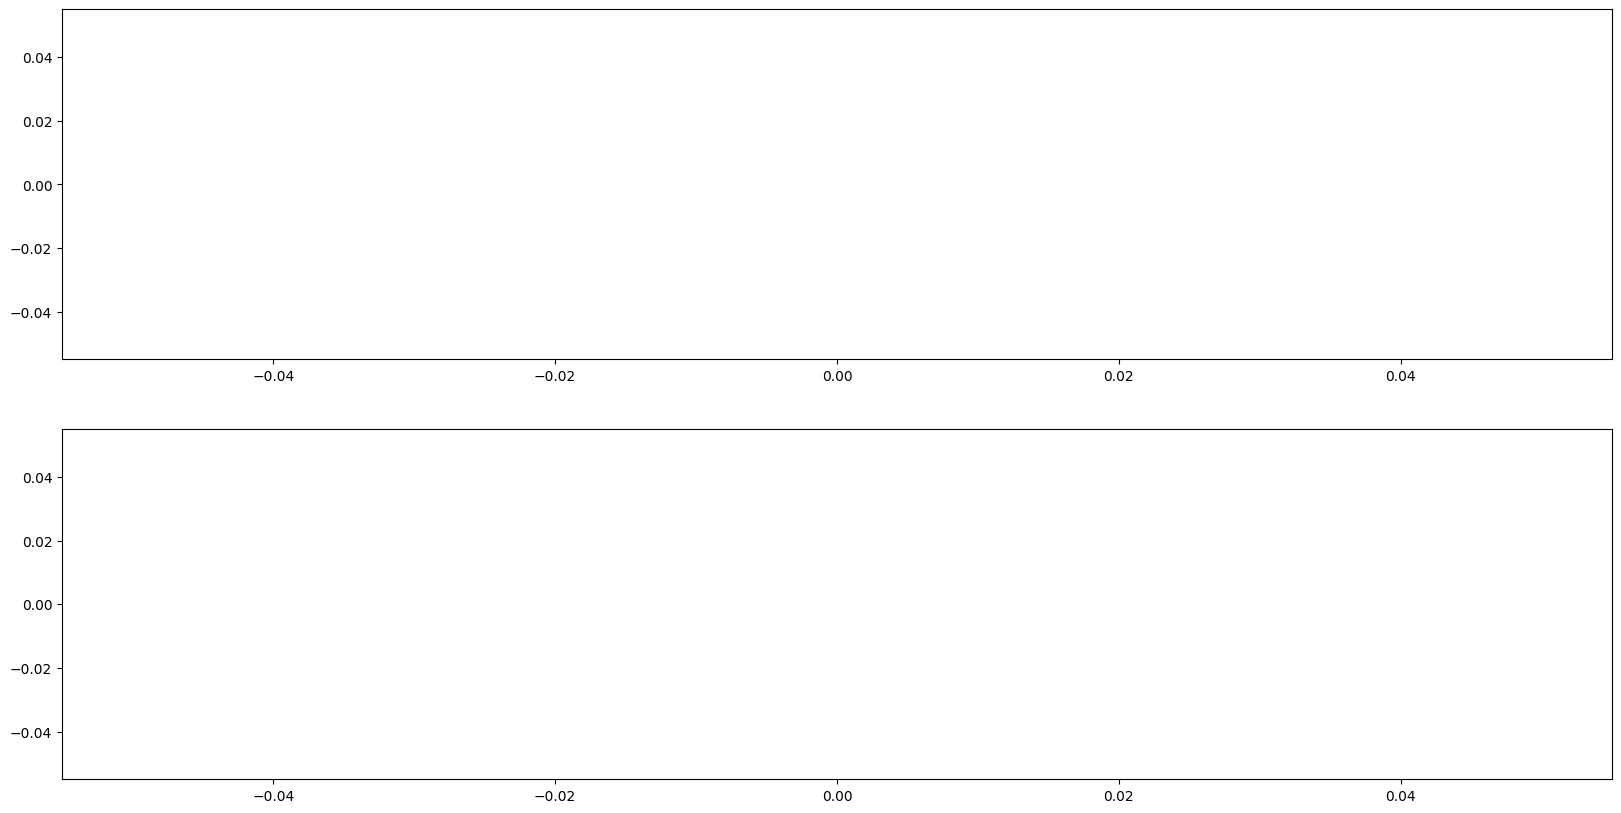

In [364]:
plot_series(series_id=series_ids[0], from_time='02-02 00:00', upto_time='02-03 00:00')

In [398]:
def generate_training_input(series_id, input_len=512, sleep=False):
    series = data.loc[data['series_id'] == series_id].copy()
    series = series.sort_values('timestamp')
    
    series_events = events.loc[events['series_id'] == series_id].copy()
    series_events = series_events.sort_values('timestamp')
    
    
    series['anglez'] = (series['anglez'] - series['anglez'].min()) / (series['anglez'].max() - series['anglez'].min())
    series['enmo'] = (series['enmo'] - series['enmo'].min()) / (series['enmo'].max() - series['enmo'].min())
    series['hour_normalized'] = series['timestamp'].dt.hour / 23
    
    # selecting onset events where there is an event on the previous night 
    # this protects against missing timestamps where we don't know what events 
    # occurred in the gap
    sleep_idxs = np.where((series_events['event'] == 'onset') & 
                          (
                                  (series_events['night'].diff() == 1) | 
                                  (series_events['night'] == 1))
                          )[0]
    sleep_idx = np.random.choice(sleep_idxs, size=1)[0]
    sleep_night = series_events.iloc[sleep_idx]['night']
    sleep_time = series_events[(series_events['night'] == sleep_night) & 
                               (series_events['event'] == 'onset')]['timestamp'].iloc[0]
    if sleep:
        wake_time = series_events[(series_events['night'] == sleep_night) & 
                                   (series_events['event'] == 'wakeup')]['timestamp'].iloc[0]
    
        indices = np.where((series['timestamp'] >= sleep_time) & (series['timestamp'] <= wake_time))[0]
        indices = indices[:-input_len]
    else:
        if sleep_night == 1:
            start_time = series.iloc[0]['timestamp']
        else:
            start_time = series_events.iloc[sleep_idx-1]['timestamp']
            
        indices = np.where((series['timestamp'] > start_time) & (series['timestamp'] < sleep_time))[0]
        indices = indices[:-input_len]
        
    start_index = np.random.choice(indices)
    timesteps = series.iloc[start_index:start_index+input_len]
    
    x = np.zeros((3, input_len))
    x[0] = timesteps['anglez']
    x[1] = timesteps['enmo']
    x[2] = timesteps['hour_normalized']
    fig, ax = plt.subplots(nrows=3, figsize=(20, 10))
    ax[0].plot(x[0])
    ax[1].plot(x[1])
    ax[2].plot(x[2])
    
    plt.show()
        
    plot_series(series_id=series_id, from_time=timesteps['timestamp'].iloc[0], 
                upto_time=timesteps['timestamp'].iloc[-1])

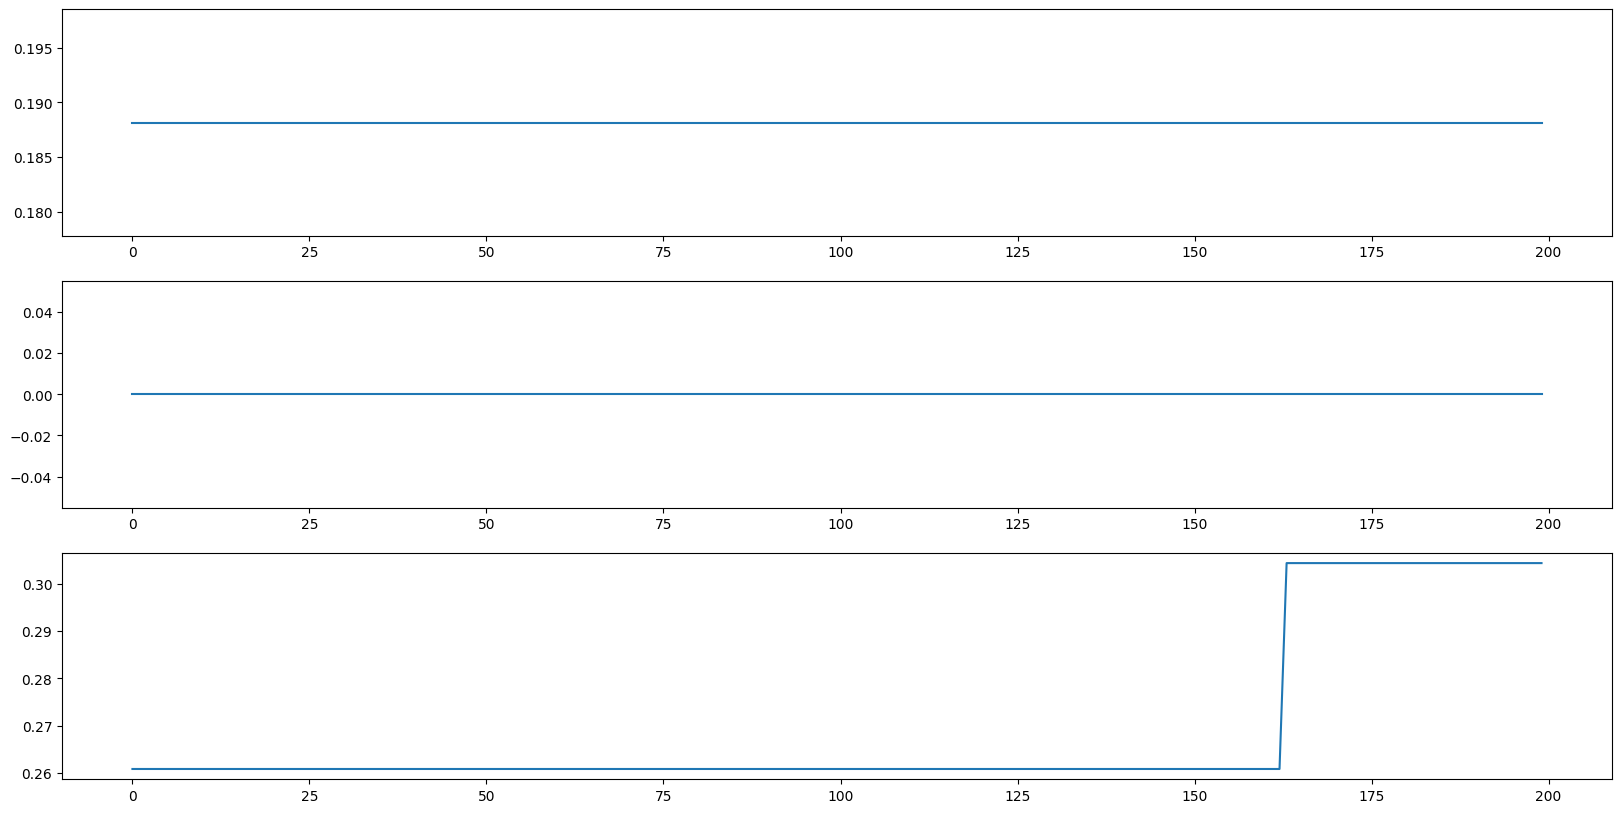

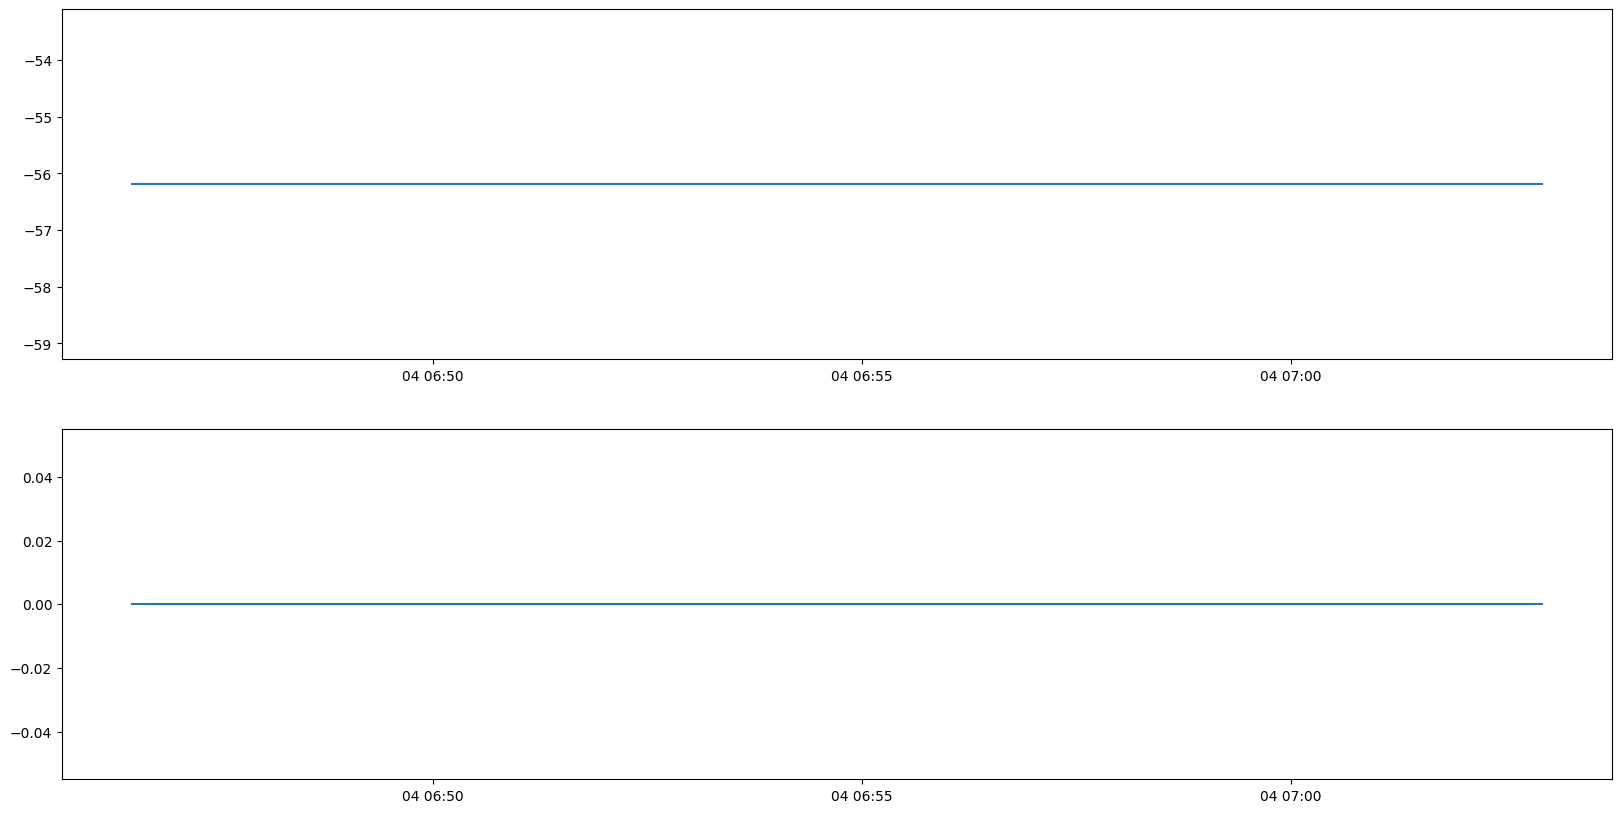

In [402]:
generate_training_input(series_id=series_ids[1], input_len=200, sleep=True)

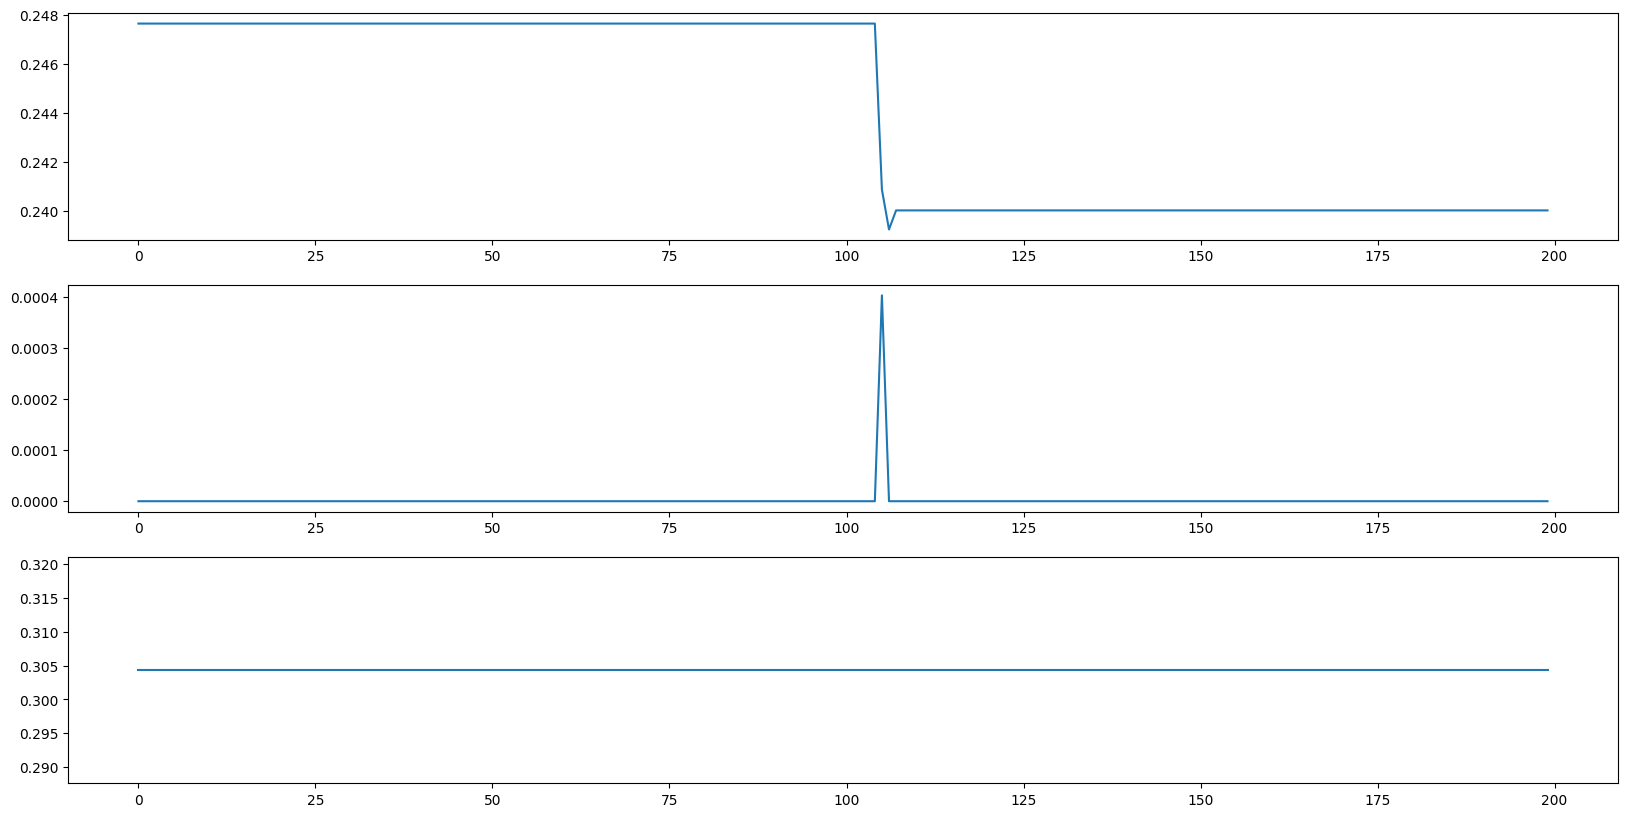

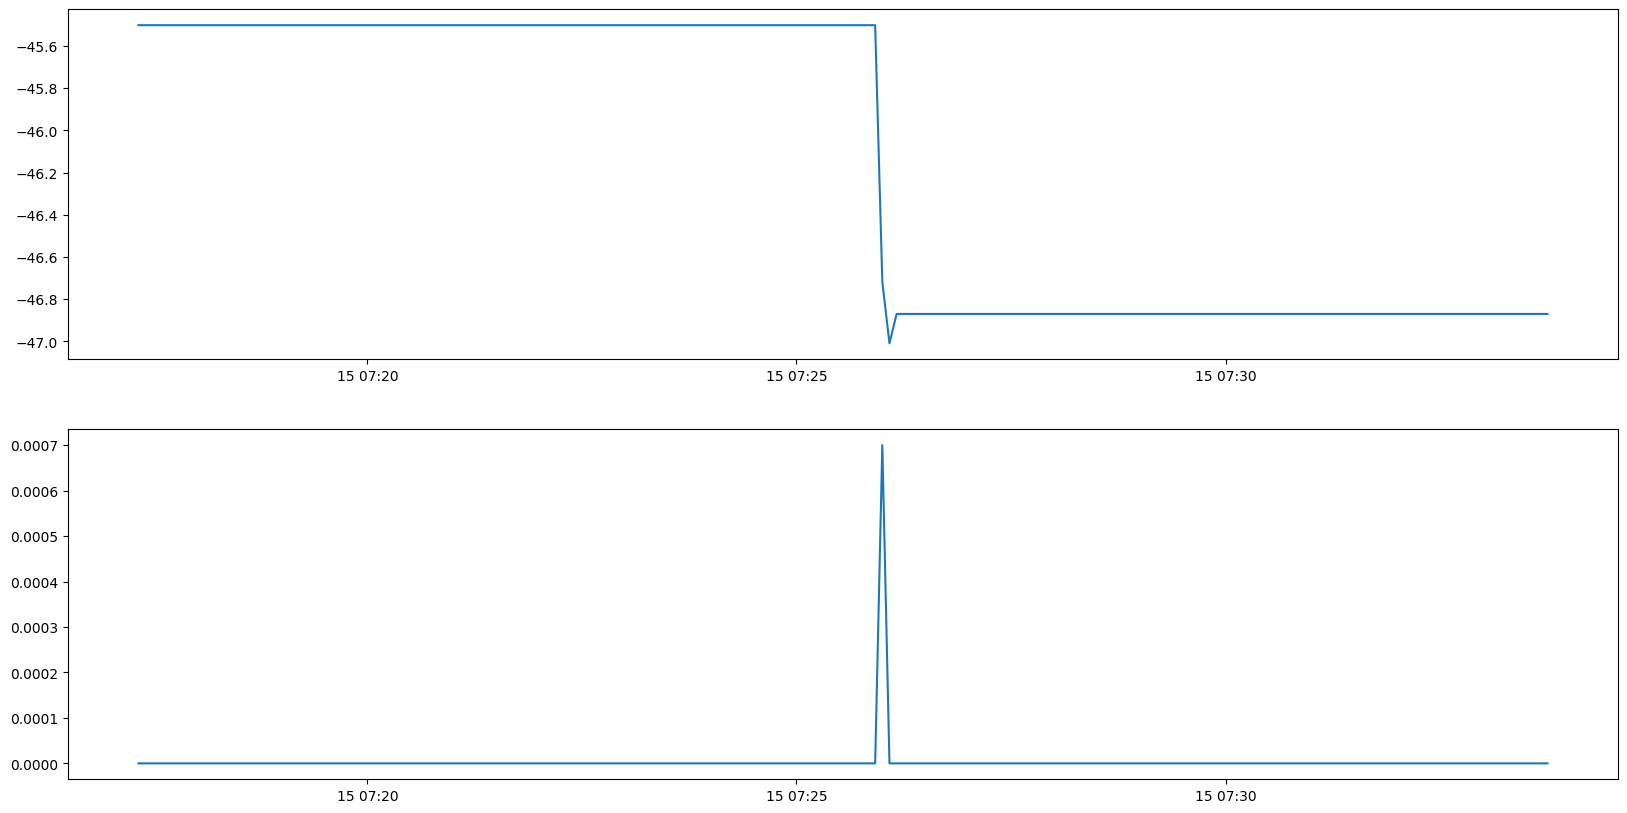

In [407]:
generate_training_input(series_id=series_ids[1], input_len=200, sleep=True)